In [44]:
cd /content/drive/MyDrive/Facial emotion recognition by AK

/content/drive/MyDrive/Facial emotion recognition by AK


In [45]:

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import os
import joblib
import matplotlib.pyplot as plt
import cv2

In [46]:
def load_dataset(image_dir, img_size=(180, 180), color_mode='grayscale', batch_size=32):
    dataset = tf.keras.utils.image_dataset_from_directory(
        image_dir,
        label_mode='int',
        image_size=img_size,
        color_mode=color_mode,
        batch_size=batch_size,
        seed=42
    )
    normalization = layers.Rescaling(1./255)
    return dataset.map(lambda x, y: (normalization(x), y))

def flatten_images(dataset):
    X, y = [], []
    for images, labels in dataset:
        X.append(images.numpy().reshape(images.shape[0], -1))
        y.append(labels.numpy())
    return np.concatenate(X), np.concatenate(y)

# def apply_svd(X, n_components=324):
#     side_len = int(np.sqrt(n_components))
#     assert side_len ** 2 == n_components, "n_components must be a perfect square"

#     svd = TruncatedSVD(n_components=n_components, random_state=42)
#     X_reduced = svd.fit_transform(X)
#     X_reshaped = X_reduced.reshape(-1, side_len, side_len, 1)
#     return X_reshaped

def apply_svd(X, n_components=324, save_path=None):
    side_len = int(np.sqrt(n_components))
    assert side_len ** 2 == n_components, "n_components must be a perfect square"

    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_reduced = svd.fit_transform(X)

    if save_path:
        joblib.dump(svd, save_path)
        print(f"SVD model saved to {save_path}")

    X_reshaped = X_reduced.reshape(-1, side_len, side_len, 1)
    return X_reshaped


def split_dataset(X, y, test_size=0.2):
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

def build_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32, lr=1e-4):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
    ]

    history = model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=callbacks)

    return model, history

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, class_names, history):
    # Predict class probabilities
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Print text metrics
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Seaborn heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()

    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    plt.figure(figsize=(14, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()

    plt.show()

def balance_with_smote(X, y):
    X_flat = X.reshape(X.shape[0], -1)
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_flat, y)
    X_res = X_res.reshape(-1, X.shape[1], X.shape[2], 1)
    return X_res, y_res



Active: 700 images
Boredom: 603 images
Confusion: 452 images
Engagement: 726 images
Frustration: 408 images
Sleep: 439 images
Yawn: 481 images


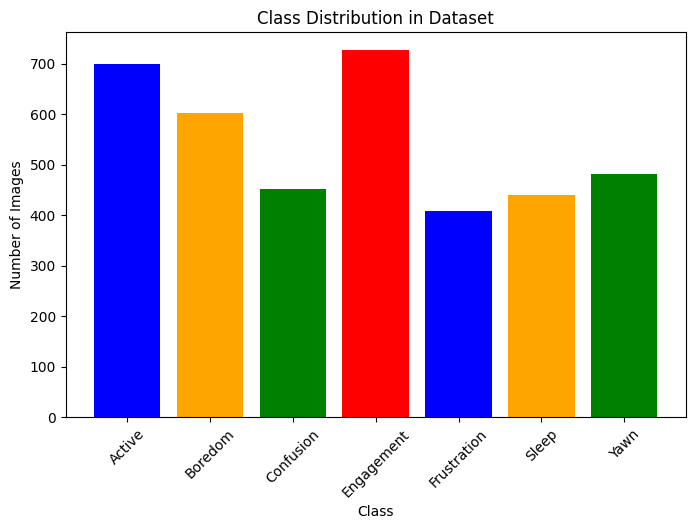

In [47]:
class_names = ['Active', 'Boredom', 'Confusion', 'Engagement', 'Frustration', 'Sleep', 'Yawn']
DATASET_PATH = "image_data/train"

# Count images per class
class_counts = {class_name: len(os.listdir(os.path.join(DATASET_PATH, class_name)))
                for class_name in class_names
                if os.path.isdir(os.path.join(DATASET_PATH, class_name))}

# Print counts
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Plot class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=45)
plt.show()


Found 3809 files belonging to 7 classes.
SVD model saved to svd.pkl
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1885 - loss: 1.9372

128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.1895 - loss: 1.9360 - val_accuracy: 0.4071 - val_loss: 1.7718
Epoch 2/50
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3736 - loss: 1.7481

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3741 - loss: 1.7471 - val_accuracy: 0.5359 - val_loss: 1.5916
Epoch 3/50
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4582 - loss: 1.5652

128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4585 - loss: 1.5646 - val_accuracy: 0.6018 - val_loss: 1.4061
Epoch 4/50
124/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5219 - loss: 1.3979

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5221 - loss: 1.3967 - val_accuracy: 0.6155 - val_loss: 1.2549
Epoch 5/50
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5679 - loss: 1.2495

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5681 - loss: 1.2490 - val_accuracy: 0.6264 - val_loss: 1.1219
Epoch 6/50
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5975 - loss: 1.1297

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5979 - loss: 1.1289 - val_accuracy: 0.6883 - val_loss: 1.0136
Epoch 7/50
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6350 - loss: 1.0406

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6349 - loss: 1.0400 - val_accuracy: 0.6991 - val_loss: 0.9445
Epoch 8/50
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6502 - loss: 0.9639

128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6504 - loss: 0.9636 - val_accuracy: 0.6962 - val_loss: 0.8832
Epoch 9/50
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6786 - loss: 0.8935

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6785 - loss: 0.8936 - val_accuracy: 0.7109 - val_loss: 0.8280
Epoch 10/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6772 - loss: 0.8622

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6774 - loss: 0.8620 - val_accuracy: 0.7365 - val_loss: 0.7856
Epoch 11/50
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7102 - loss: 0.8039

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7102 - loss: 0.8039 - val_accuracy: 0.7237 - val_loss: 0.7542
Epoch 12/50
124/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7242 - loss: 0.7702

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7241 - loss: 0.7703 - val_accuracy: 0.7316 - val_loss: 0.7365
Epoch 13/50
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7353 - loss: 0.7374

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7353 - loss: 0.7373 - val_accuracy: 0.7512 - val_loss: 0.6921
Epoch 14/50
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7590 - loss: 0.6843

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7589 - loss: 0.6849 - val_accuracy: 0.7640 - val_loss: 0.6595
Epoch 15/50
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7616 - loss: 0.6826

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7617 - loss: 0.6824 - val_accuracy: 0.7788 - val_loss: 0.6425
Epoch 16/50
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7638 - loss: 0.6617

128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7638 - loss: 0.6616 - val_accuracy: 0.7906 - val_loss: 0.6161
Epoch 17/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7797 - loss: 0.6227

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7798 - loss: 0.6226 - val_accuracy: 0.8024 - val_loss: 0.5874
Epoch 18/50
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7949 - loss: 0.6008

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7949 - loss: 0.6007 - val_accuracy: 0.8004 - val_loss: 0.5697
Epoch 19/50
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7808 - loss: 0.5923

128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7810 - loss: 0.5921 - val_accuracy: 0.8063 - val_loss: 0.5559
Epoch 20/50
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7973 - loss: 0.5627

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7974 - loss: 0.5625 - val_accuracy: 0.8230 - val_loss: 0.5325
Epoch 21/50
124/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8156 - loss: 0.5472

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8157 - loss: 0.5468 - val_accuracy: 0.8210 - val_loss: 0.5169
Epoch 22/50
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8383 - loss: 0.4880

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8381 - loss: 0.4884 - val_accuracy: 0.8230 - val_loss: 0.5075
Epoch 23/50
124/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8208 - loss: 0.5078

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8209 - loss: 0.5075 - val_accuracy: 0.8358 - val_loss: 0.4854
Epoch 24/50
124/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8212 - loss: 0.5037

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8216 - loss: 0.5028 - val_accuracy: 0.8446 - val_loss: 0.4833
Epoch 25/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8473 - loss: 0.4530

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8473 - loss: 0.4530 - val_accuracy: 0.8545 - val_loss: 0.4527
Epoch 26/50
124/128 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8442 - loss: 0.4576

128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8444 - loss: 0.4573 - val_accuracy: 0.8604 - val_loss: 0.4465
Epoch 27/50
123/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8462 - loss: 0.4419

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8464 - loss: 0.4415 - val_accuracy: 0.8466 - val_loss: 0.4339
Epoch 28/50
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8570 - loss: 0.4134

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8571 - loss: 0.4132 - val_accuracy: 0.8623 - val_loss: 0.4254
Epoch 29/50
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8674 - loss: 0.3925

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8674 - loss: 0.3926 - val_accuracy: 0.8653 - val_loss: 0.4070
Epoch 30/50
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8661 - loss: 0.3959

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8661 - loss: 0.3958 - val_accuracy: 0.8781 - val_loss: 0.4013
Epoch 31/50
124/128 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8759 - loss: 0.3791

128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8759 - loss: 0.3790 - val_accuracy: 0.8751 - val_loss: 0.3860
Epoch 32/50
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8944 - loss: 0.3428

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8942 - loss: 0.3431 - val_accuracy: 0.8712 - val_loss: 0.3775
Epoch 33/50
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8740 - loss: 0.3644

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8742 - loss: 0.3641 - val_accuracy: 0.8830 - val_loss: 0.3679
Epoch 34/50
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8982 - loss: 0.3191

128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8981 - loss: 0.3194 - val_accuracy: 0.8800 - val_loss: 0.3548
Epoch 35/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8902 - loss: 0.3351 - val_accuracy: 0.8889 - val_loss: 0.3550
Epoch 36/50
124/128 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8988 - loss: 0.3078

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8986 - loss: 0.3080 - val_accuracy: 0.8899 - val_loss: 0.3449
Epoch 37/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8978 - loss: 0.3217 - val_accuracy: 0.8859 - val_loss: 0.3456
Epoch 38/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8943 - loss: 0.3035 - val_accuracy: 0.8771 - val_loss: 0.3535
Epoch 39/50
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9202 - loss: 0.2638

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9200 - loss: 0.2640 - val_accuracy: 0.8899 - val_loss: 0.3351
Epoch 40/50
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9189 - loss: 0.2553

128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9187 - loss: 0.2557 - val_accuracy: 0.8938 - val_loss: 0.3258
Epoch 41/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9185 - loss: 0.2626

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9184 - loss: 0.2626 - val_accuracy: 0.8889 - val_loss: 0.3170
Epoch 42/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9116 - loss: 0.2657

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9117 - loss: 0.2656 - val_accuracy: 0.9027 - val_loss: 0.3066
Epoch 43/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9183 - loss: 0.2491 - val_accuracy: 0.8899 - val_loss: 0.3133
Epoch 44/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9180 - loss: 0.2556

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9181 - loss: 0.2555 - val_accuracy: 0.8968 - val_loss: 0.2978
Epoch 45/50
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9301 - loss: 0.2308

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9301 - loss: 0.2307 - val_accuracy: 0.9036 - val_loss: 0.2885
Epoch 46/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9295 - loss: 0.2364 - val_accuracy: 0.9095 - val_loss: 0.2908
Epoch 47/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9308 - loss: 0.2225 - val_accuracy: 0.9027 - val_loss: 0.2899
Epoch 48/50
124/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9374 - loss: 0.2040

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9373 - loss: 0.2045 - val_accuracy: 0.9056 - val_loss: 0.2808
Epoch 49/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9329 - loss: 0.2056 - val_accuracy: 0.8928 - val_loss: 0.2934
Epoch 50/50
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9279 - loss: 0.2147

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9280 - loss: 0.2145 - val_accuracy: 0.9164 - val_loss: 0.2704
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Classification Report:
               precision    recall  f1-score   support

      Active       0.88      0.82      0.85       145
     Boredom       0.89      0.94      0.92       145
   Confusion       0.94      0.96      0.95       145
  Engagement       0.97      0.87      0.92       146
 Frustration       0.92      0.93      0.92       145
       Sleep       0.90      0.94      0.92       145
        Yawn       0.93      0.95      0.94       146

    accuracy                           0.92      1017
   macro avg       0.92      0.92      0.92      1017
weighted avg       0.92      0.92      0.92      1017



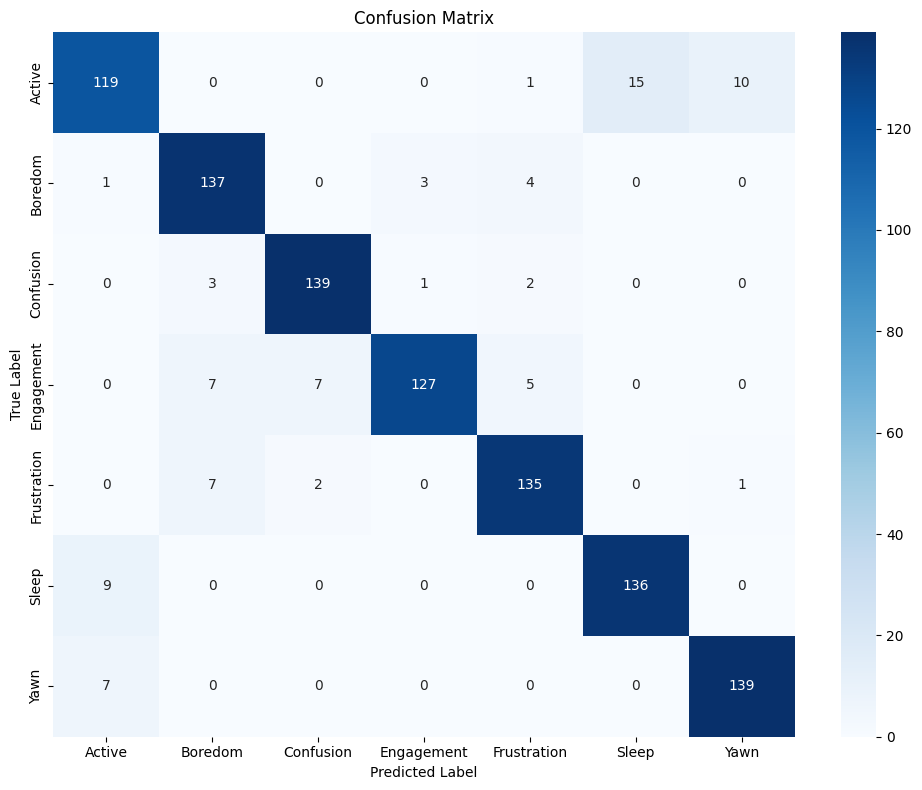

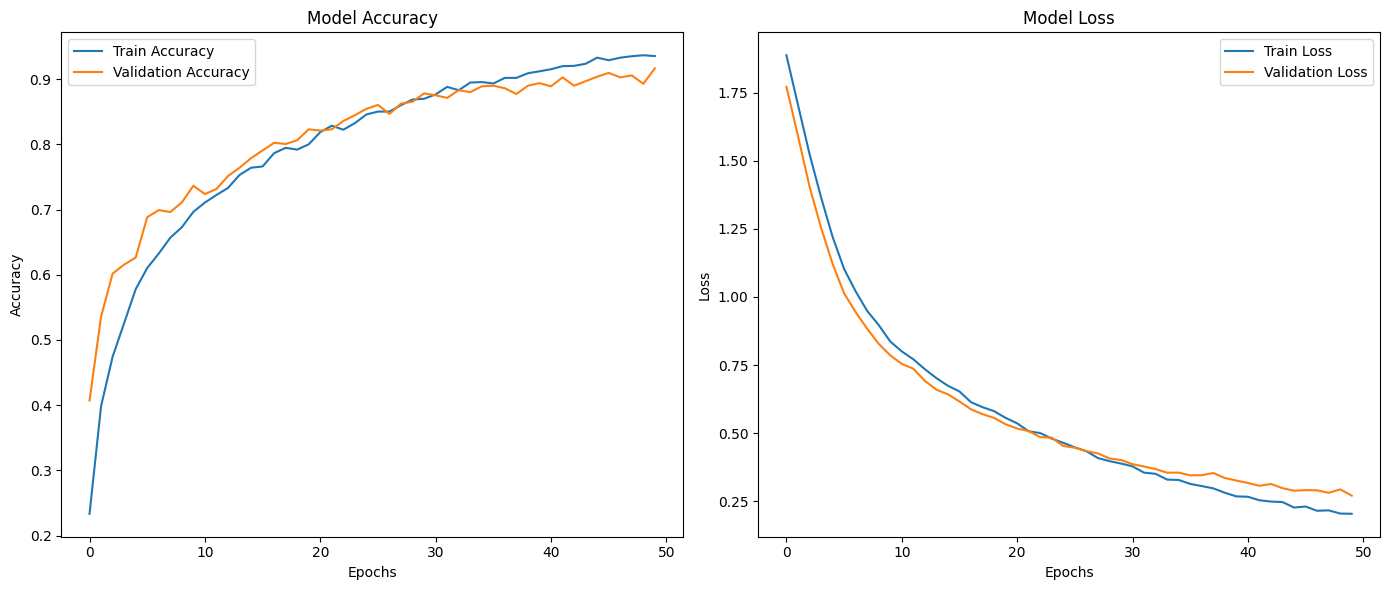

In [48]:
image_dir = 'image_data/train'  # update with actual path
n_components = 324  # 18x18

# Load and preprocess
dataset = load_dataset(image_dir)
X, y = flatten_images(dataset)
X_svd = apply_svd(X, n_components=324, save_path='svd.pkl')
X_balanced, y_balanced = balance_with_smote(X_svd, y)

# Split
X_train, X_val, y_train, y_val = split_dataset(X_balanced, y_balanced)

# Model
input_shape = X_train.shape[1:]
model = build_cnn(input_shape, num_classes=7)
model, history = train_model(model, X_train, y_train, X_val, y_val)

# Evaluate
evaluate_model(model, X_val, y_val, class_names, history)

In [49]:
import matplotlib.pyplot as plt

def show_sample_predictions(model, X, y_true, class_names, num_samples=9):

    # Select random indices
    indices = np.random.choice(len(X), num_samples, replace=False)
    X_sample = X[indices]
    y_sample = y_true[indices]

    # Predict
    y_pred_probs = model.predict(X_sample)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Plot
    plt.figure(figsize=(12, 12))
    for i in range(num_samples):
        plt.subplot(int(np.sqrt(num_samples)), int(np.sqrt(num_samples)), i + 1)
        image = X_sample[i].squeeze()
        plt.imshow(image, cmap='gray')
        true_label = class_names[y_sample[i]]
        pred_label = class_names[y_pred[i]]
        color = 'green' if y_sample[i] == y_pred[i] else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [50]:
from joblib import load
svd = load("svd.pkl")
def transform_image_with_svd(img_gray, svd, img_size=(180, 180)):
    flat = img_gray.reshape(1, -1)  # (1, H*W)
    reduced = svd.transform(flat)   # (1, n_components)
    side = int(np.sqrt(svd.n_components))
    return reduced.reshape(1, side, side, 1)  # (1, side, side, 1)

def show_predictions(model, class_names, samples, svd, img_size=(180, 180)):
    plt.figure(figsize=(16, 14))
    for idx, (img_path, true_label) in enumerate(samples):
        # Load RGB for display
        img_rgb = cv2.imread(img_path)
        img_rgb = cv2.resize(img_rgb, img_size)
        img_rgb = img_rgb.astype("float32") / 255.0

        # Convert to grayscale for inference
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
        img_gray = img_gray.reshape(img_size[0], img_size[1], 1)

        # Apply SVD transform
        input_tensor = transform_image_with_svd(img_gray, svd, img_size)

        # Predict
        preds = model.predict(input_tensor, verbose=0)[0]
        pred_idx = np.argmax(preds)
        pred_label = class_names[pred_idx]
        confidence = preds[pred_idx]

        # Display RGB
        plt.subplot(7, 5, idx + 1)
        plt.imshow(cv2.cvtColor((img_rgb * 255).astype("uint8"), cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(
            f"Actual: {true_label}\nPred: {pred_label} ({confidence:.2f})",
            color='green' if pred_label == true_label else 'red',
            fontsize=10
        )
    plt.tight_layout()
    plt.show()

import random
def get_sample_images_per_class(data_dir, class_names, num_samples=5):
    samples = []
    for cls in class_names:
        cls_path = os.path.join(data_dir, cls)
        images = os.listdir(cls_path)
        selected = random.sample(images, num_samples)
        for img in selected:
            samples.append((os.path.join(cls_path, img), cls))
    return samples


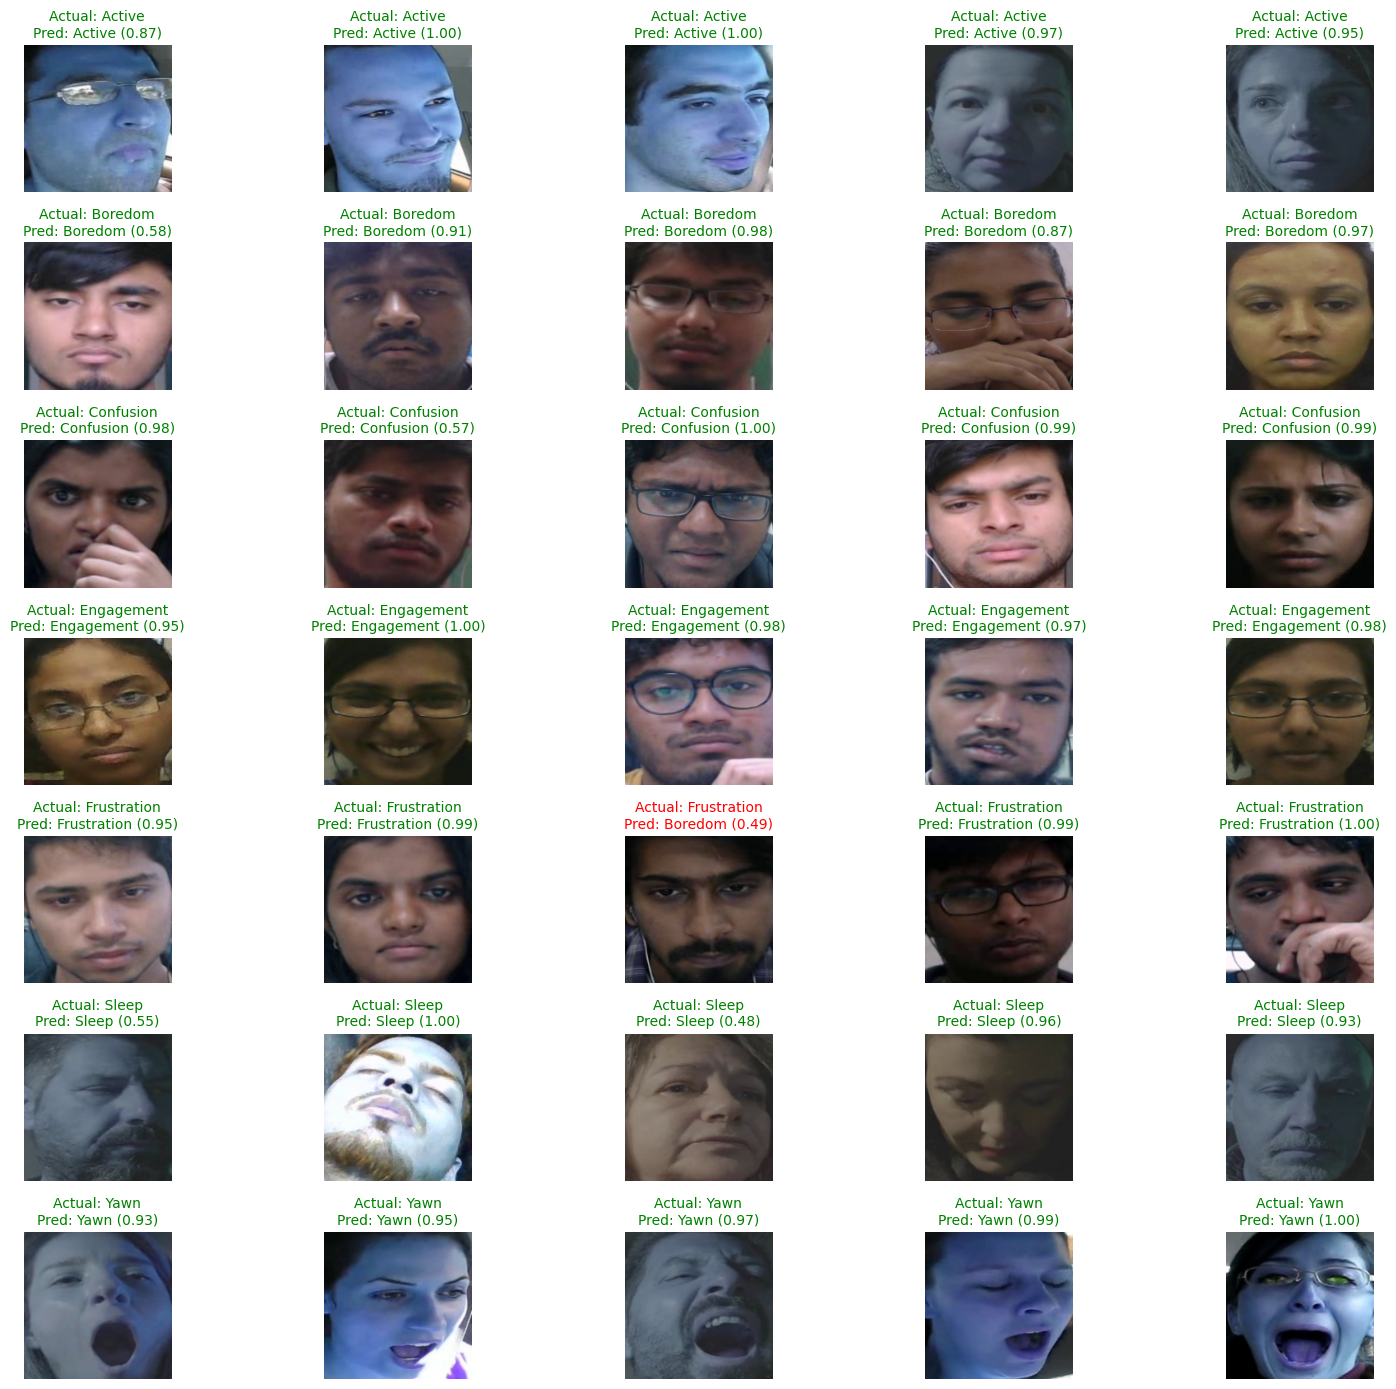

In [51]:
class_names = sorted(os.listdir("image_data/train"))
samples = get_sample_images_per_class("image_data/train", class_names, num_samples=5)
show_predictions(model, class_names, samples, svd, img_size=(180, 180))


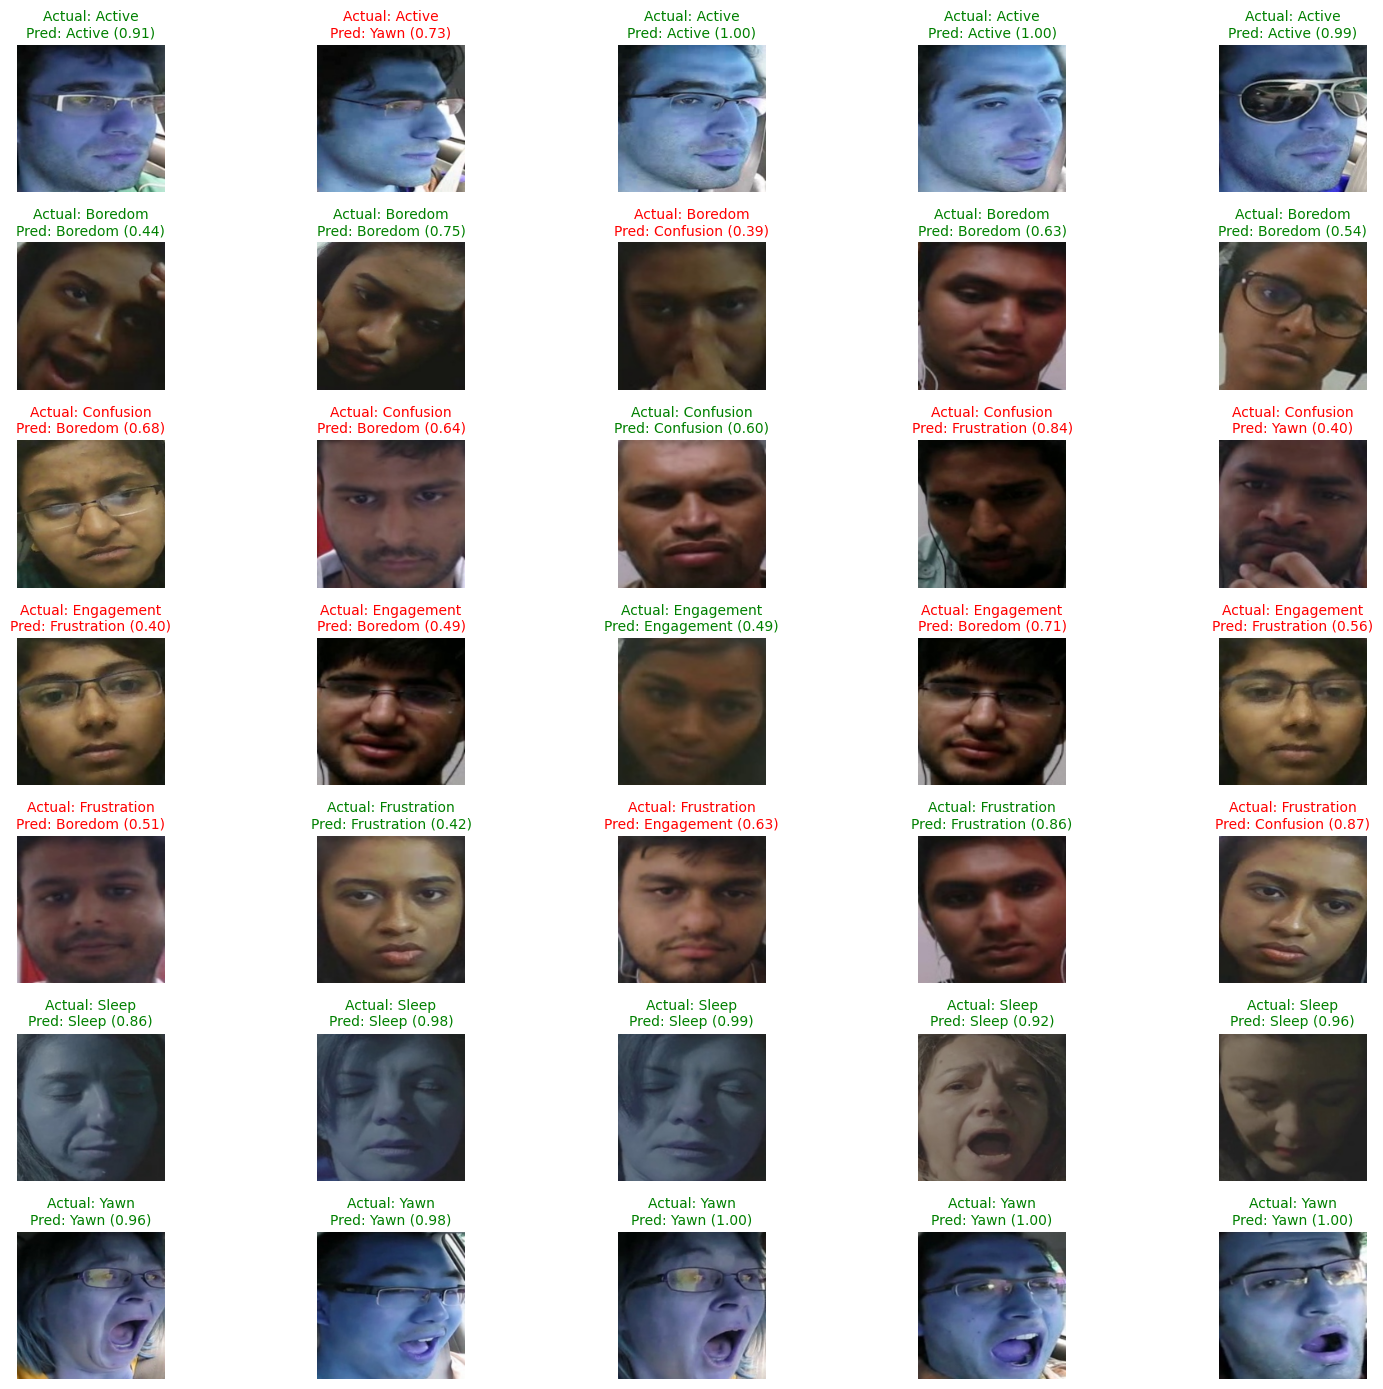

In [52]:
class_names = sorted(os.listdir("image_data/test"))
samples = get_sample_images_per_class("image_data/test", class_names, num_samples=5)
show_predictions(model, class_names, samples, svd, img_size=(180, 180))
